# 0. Install necessary libraries(optional)

In [1]:
# Install necessary libraries
!pip install opencv-python-headless imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 273.5 kB/s eta 0:00:0000:0100:07


# 1. Import libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

# 2. Data Preprocessing and SVM Feature Extraction

In [3]:
# Function to calculate features
def extract_features(blob, hsv_img):
    x, y, w, h = cv2.boundingRect(blob)
    mask = np.zeros(hsv_img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [blob], -1, 255, -1)

    # Position Features
    moments = cv2.moments(mask)
    if moments['m00'] != 0:
        center_x = int(moments['m10'] / moments['m00'])
        center_y = int(moments['m01'] / moments['m00'])
    else:
        center_x, center_y = 0, 0

    # Brightness Features
    blob_pixels = hsv_img[mask == 255][:, 2]  # Value channel in HSV
    avg_intensity = np.mean(blob_pixels)
    intensity_variance = np.var(blob_pixels)

    # Shape Features
    area = cv2.contourArea(blob)
    bbox_area = w * h
    aspect_ratio = float(w) / h if h != 0 else 0
    radius_mean = np.mean([np.sqrt((pt[0][0] - center_x)**2 + (pt[0][1] - center_y)**2) for pt in blob])
    radius_variance = np.var([np.sqrt((pt[0][0] - center_x)**2 + (pt[0][1] - center_y)**2) for pt in blob])
    
    # Halo approximation (binary approximation as additional layer processing is needed)
    halo_size = 0  
    halo_ratio = halo_size / area if area != 0 else 0

    # Color Features
    hsv_values = hsv_img[mask == 255]
    dominant_hue = np.mean(hsv_values[:, 0])
    avg_saturation = np.mean(hsv_values[:, 1])
    avg_value = np.mean(hsv_values[:, 2])

    # Motion Features (placeholder, requires sequence data)
    motion_features = [0, 0, 0, 0, 0]  # Use motion capture over frames for real data

    # Combine features
    features = [
        center_x, center_y, avg_intensity, intensity_variance, area, aspect_ratio,
        radius_mean, radius_variance, halo_size, halo_ratio, dominant_hue, 
        avg_saturation, avg_value, *motion_features
    ]
    return features

# Data preprocessing and feature extraction
def process_image(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY) # threshold = 200

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = [extract_features(contour, hsv_img) for contour in contours]
    return features

# 3. Dataset Preparation

In [4]:
# Mock Dataset Preparation
# Replace with actual labeled dataset of images and corresponding labels
images = []  # Load images as numpy arrays
labels = []  # Labels: 1 for headlights, 2 for taillights, etc.

for image_path in ["embedded_dataset/bright", "embedded_dataset/dim"]:
    for file_name in os.listdir(image_path):
        img_path = os.path.join(image_path, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            label = image_path.split('/')
            labels.append(label[1])
            
all_features = []
all_labels = []

for img, label in zip(images, labels):
    features = process_image(img)
    all_features.extend(features)
    all_labels.extend([label] * len(features))

# Check unique classes in labels
unique_classes = np.unique(all_labels)
print("Unique classes in dataset:", unique_classes)

Unique classes in dataset: ['bright' 'dim']


# 4. Oversampling using SMOTE (optional)

In [5]:
# Ensure there are at least two classes
if len(unique_classes) < 2:
    print("Error: The dataset does not have enough classes for classification.")
    # Optionally oversample using SMOTE
    smote = SMOTE(random_state=42)
    all_features, all_labels = smote.fit_resample(all_features, all_labels)
    print("After applying SMOTE, unique classes:", np.unique(all_labels))

# 5. Train the SVM Model

In [6]:
# Train and evaluate SVM model
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)

# Verify classes in y_train
unique_train_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_train_classes)

if len(unique_train_classes) < 2:
    raise ValueError("Insufficient classes in the training set. Check dataset preparation.")

Unique classes in y_train: ['bright' 'dim']


In [10]:
svm = SVC(kernel='linear', C=1.0, probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

# 6. Prediction

In [11]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      bright       0.81      0.96      0.88        26
         dim       0.92      0.65      0.76        17

    accuracy                           0.84        43
   macro avg       0.86      0.80      0.82        43
weighted avg       0.85      0.84      0.83        43



# 7. Visualizing Results

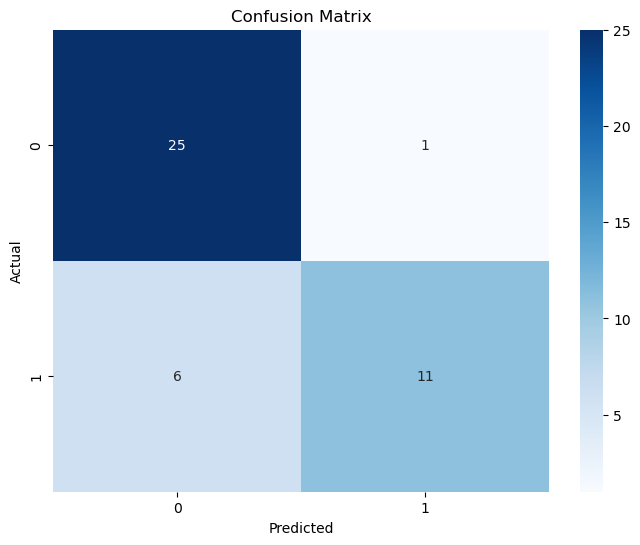

In [18]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

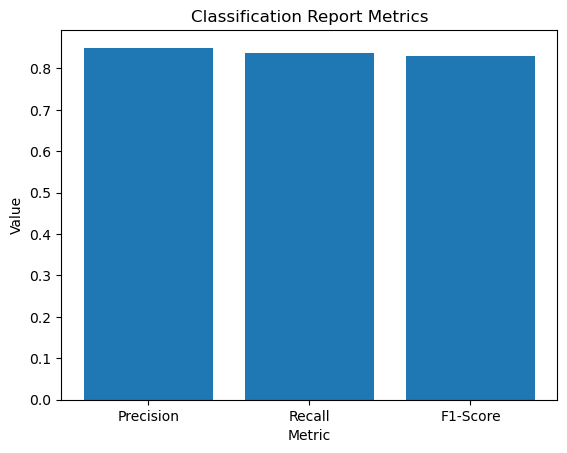

In [22]:
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Visualize metrics
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

plt.bar(metrics, values)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Classification Report Metrics')
plt.show()



Training SVM...

SVM Classification Report:
               precision    recall  f1-score   support

      bright       0.81      0.96      0.88        26
         dim       0.92      0.65      0.76        17

    accuracy                           0.84        43
   macro avg       0.86      0.80      0.82        43
weighted avg       0.85      0.84      0.83        43

SVM Confusion Matrix:
 [[25  1]
 [ 6 11]]


Training Random Forest...

Random Forest Classification Report:
               precision    recall  f1-score   support

      bright       0.80      0.92      0.86        26
         dim       0.85      0.65      0.73        17

    accuracy                           0.81        43
   macro avg       0.82      0.79      0.80        43
weighted avg       0.82      0.81      0.81        43

Random Forest Confusion Matrix:
 [[24  2]
 [ 6 11]]


Training Logistic Regression...

Logistic Regression Classification Report:
               precision    recall  f1-score   support

    

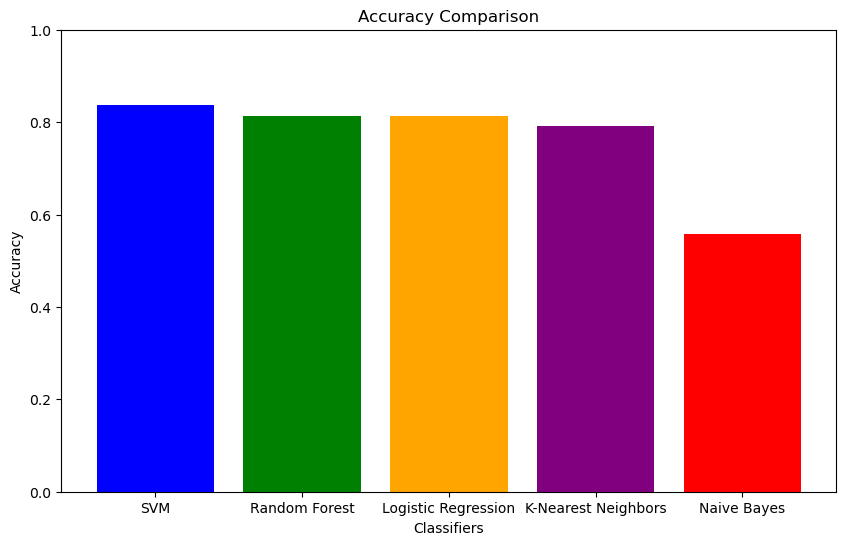

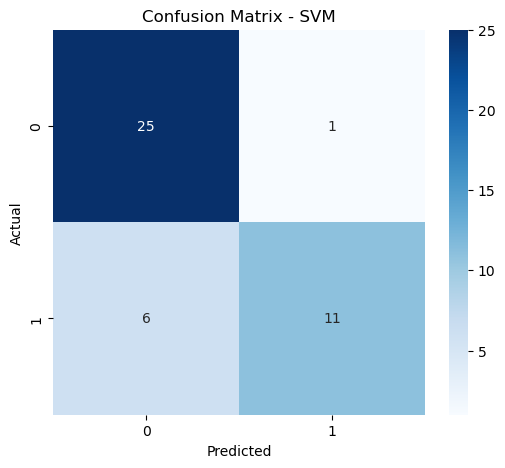

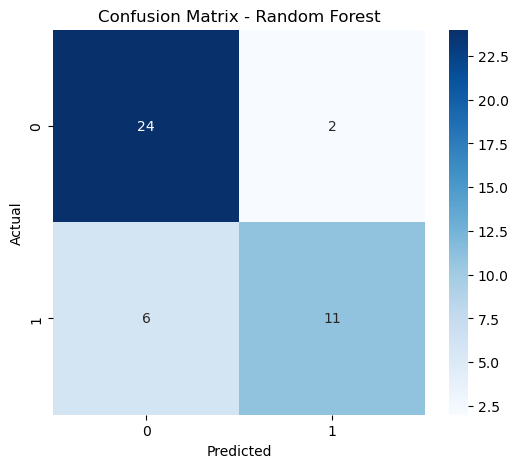

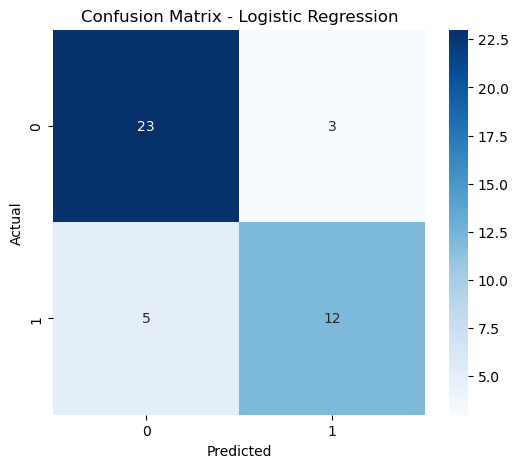

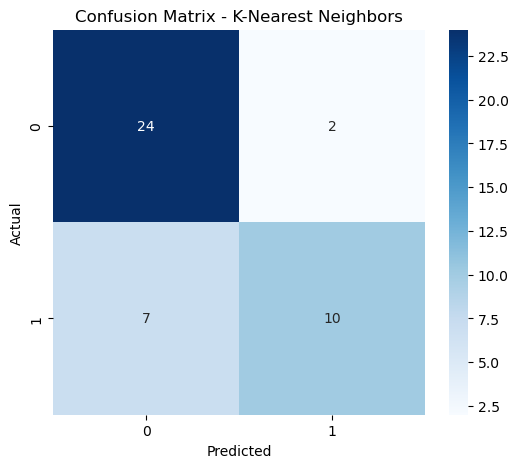

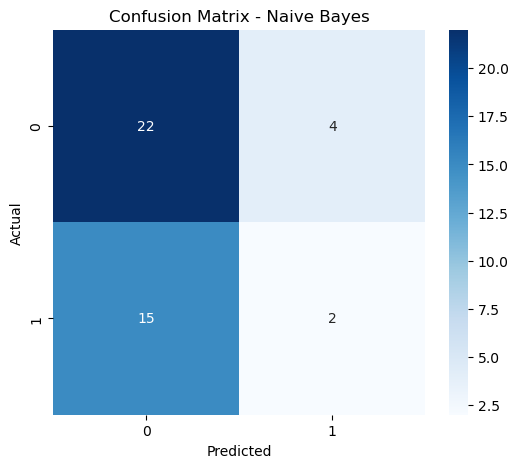

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train and Evaluate Multiple Classifiers
def train_and_evaluate_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        "SVM": SVC(kernel='linear', C=1.0, probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Naive Bayes": GaussianNB()
    }

    results = {}
    confusion_matrices = {}

    for name, model in classifiers.items():
        print(f"\n\nTraining {name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Save performance metrics
        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred, output_dict=True)
        }
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
        print(f"{name} Confusion Matrix:\n", confusion_matrices[name])

    return results, confusion_matrices

# Visualize the Results
def visualize_results(results, confusion_matrices):
    # Accuracy Comparison
    accuracies = [results[clf]["accuracy"] for clf in results]
    classifiers = list(results.keys())

    plt.figure(figsize=(10, 6))
    plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
    plt.title("Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifiers")
    plt.ylim(0, 1)
    plt.show()

    # Confusion Matrices
    for clf, cm in confusion_matrices.items():
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {clf}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

# Main Code
if __name__ == "__main__":
    # Assuming 'all_features' and 'all_labels' are already prepared
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)

    # Train and Evaluate Classifiers
    results, confusion_matrices = train_and_evaluate_classifiers(X_train, X_test, y_train, y_test)

    # Visualize Results
    visualize_results(results, confusion_matrices)